# Privacy-Preserving Data Publishing

## Exercises : Partition-Based Models and Algorithms

The well-known parisien health center \emph{Brascassés} wants to share his patients' health data with epidemiologists. Before starting sharing data, the DBA of Brascassés would like to ask to an expert his opinion on the privacy guarantees of the sanitization methods used. You are the expert.

The original dataset (file './csv-patients/Jeu de donnees-Tableau 1.csv') is a table with three columns and 21 tuples. Each tuple corresponds to a different patient. The DBA has set the QI to (Age, Code postal) and the SD to Diagnostic. Based on his home-made Mondrian implementation, he has also computed four possible sanitized releases of the dataset (files './csv-patients/Partitionnement P$_i$-Tableau 1.csv', and denoted G$_i$ below). All are candidates to being published. 

**Your goal is to understand the privacy guarantees of the releases and to give your opinion on their possible publication.**

You can work with your pencil and paper, or with a PDF modifier (the figures are all given in PDF format), or with Python. We obviously recommand the latest option and prepared the Notebook below for helping you. 

### Imports and settings

In [1]:
from itertools import chain, combinations
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_colwidth', 0)

### Load data

In [2]:
def to_interval(x):
    """
    Utility function for creating panda intervals from the intervals stored in the CSV files.
    """
    return pd.Interval(*map(int, x.strip('[]').split(', ')), closed='both')

# The original dataset. 
d = pd.read_csv('./csv-patients/Jeu de donnees-Tableau 1.csv', sep=';', usecols=[1,2,3], 
                header=None, skiprows=1, names=['postcode', 'age', 'diagnostic'])

# The pair of columns that form the quasi-identifier specified by the DBA. 
qi = ['postcode', 'age']

# The column that form the sensitive data.
sd = ['diagnostic']

def read_partition(fn):
    """
    Utility function for reading a k-anonymous release stored in a CSV file. 
    """
    g = pd.read_csv(fn, sep='\t', header=None, skiprows=1, names=['postcode', 'age'], 
                    converters={'postcode': to_interval, 'age': to_interval})
    g['diagnostic'] = d.diagnostic
    return g

# Read the four releases from their corresponding files. 
g1 = read_partition('./csv-patients/Partitionnement P1-Tableau 1.csv')
g2 = read_partition('./csv-patients/Partitionnement P2-Tableau 1.csv')
g3 = read_partition('./csv-patients/Partitionnement P3-Tableau 1.csv')
g4 = read_partition('./csv-patients/Partitionnement P4-Tableau 1.csv')

In [3]:
# Plot the original dataset
d

postcode  age                  diagnostic
0   75010     22   Angine rouge              
1   75001     36   Grippe                    
2   75007     35   Angine blanche            
3   75003     24   Grippe                    
4   75008     24   Rhinopharyngite           
5   75002     35   Grippe                    
6   75001     32   Rhinopharyngite           
7   75003     37   Oblomovisme               
8   75001     38   Angine                    
9   75004     23   Grippe                    
10  75005     25   Grippe                    
11  75008     34   Angine blanche            
12  75003     23   Grippe                    
13  75006     24   Rhinopharyngite           
14  75009     30   Angine blanche            
15  75008     32   Angine                    
16  75006     31   Angine érythémateuse      
17  75004     28   Rhinopharyngite           
18  75004     34   Rhinopharyngite           
19  75001     20   Grippe                    
20  75007     38   Angine érythémato-pultacée

### Questions

<h4>1. Observe: for each release, what are the equivalence classes ? You might find it useful to give a name to each class (e.g., EC$_j$).</h4>

In [4]:
for i, g in enumerate([g1, g2, g3, g4]):
    print(f'G{i+1}')
    ec = g[qi].drop_duplicates()
    ec.index = 'EC' + ec.index.astype(str)
    display(ec)

G1


postcode       age
EC0  [75005, 75010]  [20, 40]
EC1  [75001, 75004]  [20, 40]

G2


postcode       age
EC0  [75005, 75010]  [20, 30]
EC1  [75001, 75004]  [31, 40]
EC2  [75005, 75010]  [31, 40]
EC3  [75001, 75004]  [20, 30]

G3


postcode       age
EC0   [75008, 75010]  [20, 30]
EC1   [75001, 75001]  [31, 40]
EC2   [75005, 75007]  [31, 40]
EC3   [75001, 75003]  [20, 30]
EC5   [75002, 75004]  [31, 40]
EC9   [75004, 75004]  [20, 30]
EC10  [75005, 75007]  [20, 30]
EC11  [75008, 75010]  [31, 40]

G4


postcode       age
EC0   [75008, 75010]  [20, 30]
EC1   [75001, 75004]  [31, 36]
EC2   [75005, 75007]  [31, 40]
EC3   [75001, 75003]  [20, 30]
EC7   [75001, 75004]  [37, 40]
EC9   [75004, 75004]  [20, 30]
EC10  [75005, 75007]  [20, 30]
EC11  [75008, 75010]  [31, 40]

<h4>2. Draw on a 2D graph the equivalence classes of $G_3$.</h4>

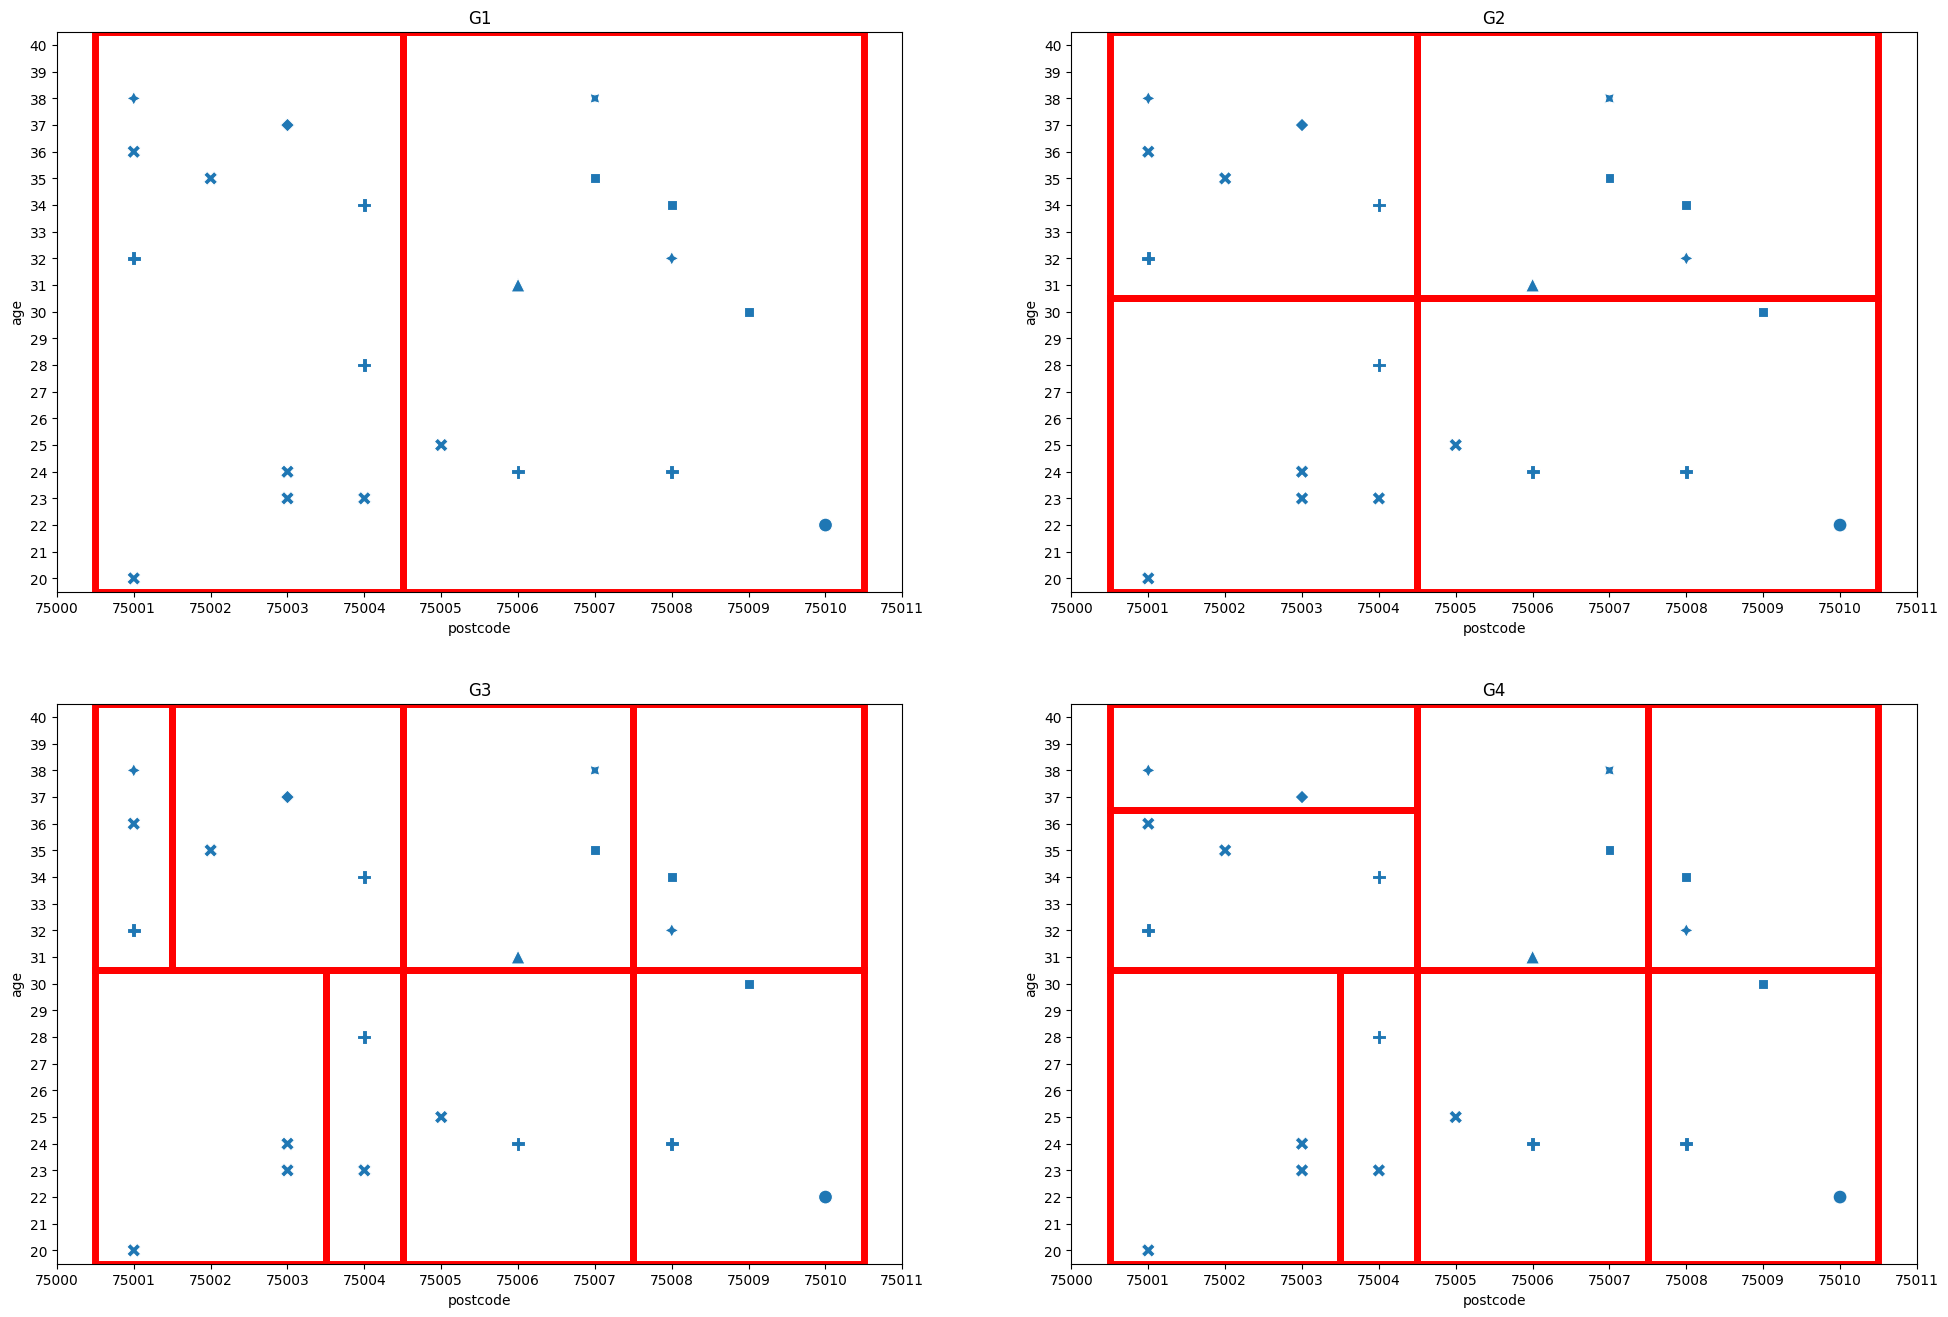

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(2*12,2*8))

for i, (g, ax) in enumerate(zip([g1, g2, g3, g4], axes.flat)):
    ax.set_title(f'G{i+1}')
    
    ax.set_ylim(19.5, 40.5)

    sns.scatterplot(x='postcode', y='age', data=d, marker='X', s=100, ax=ax, style='diagnostic')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))

    for ec in g[qi].drop_duplicates().itertuples():
        x, y = ec.postcode.left, ec.age.left
        w = ec.postcode.right - ec.postcode.left
        h = ec.age.right - ec.age.left
        r = Rectangle((x - 0.5, y - 0.5), w + 1, h + 1, 
                      linewidth=5, edgecolor='red', facecolor='none')

        ax.add_patch(r)
        ax.legend([],[], frameon=False)

<h4>3. Observe: For the top left class of $G_3$, what is the set of sensitive data?</h4>

In [6]:
set(g4.iloc[pd.IntervalIndex(g3.postcode).get_loc(d.postcode.min()) & 
            pd.IntervalIndex(g3.age).get_loc(d.age.max())].diagnostic)

{'Angine', 'Grippe', 'Rhinopharyngite'}

<h4>4. Observe: Which release satisfy k-Anonymity with : k=3? k=5? k=8?</h4>

In [7]:
def is_kanonymous(g, k):
    return g.groupby(qi).size().ge(k).all()

pd.DataFrame([[is_kanonymous(g, k) for k in [3, 5, 8]] for g in [g1, g2, g3, g4]],
             columns=['3-Anonymous', '5-Anonymous', '8-Anonymous'],
             index=['G1', 'G2', 'G3', 'G4'])

3-Anonymous  5-Anonymous  8-Anonymous
G1  True         True         True       
G2  True         True         False      
G3  False        False        False      
G4  False        False        False

<h4>5. In general, is an 8-Anonymous release also 5-Anonymous?</h4>

<h4>6. Does $G_3$ satisfy naive l-Diversity with $l=3$?</h4>

In [8]:
def is_naive_ldiverse(g, l):
    return g.groupby(by=qi).count().ge(l).eq(True).all()

is_naive_ldiverse(g3, 3)

diagnostic    False
dtype: bool

<h4>7. Bob is a patient of Brascassés. His tuple appears in the initial dataset and is equal to `(75003, 37, Oblomovisme)`. Give Bob’s possible diagnostics for an attacker receiving $G_3$ and having the following background knowledge.</h4>

1. Nothing;
2. That Bob participates to the initial dataset;
3. Idem 7.2 and that his QI is `(75003, 37)`;
4. Idem 7.3 and that Bob does not have Grippe;
5. Idem 7.3 and that Alice and Charlie (1) have participated to the dataset, (2) have QIs respectively equal to `(75002, 35)` and `(75004, 34)`, and (3) have SDs respectively equal to Grippe and Rhinopharyngite.

In [11]:
g3_idx_pc = pd.IntervalIndex(g3.postcode)
g3_idx_age = pd.IntervalIndex(g3.age)

g3_q3 = g3.iloc[g3_idx_pc.get_loc(75003) & g3_idx_age.get_loc(37)]

g3_q4 = g3_q3[(g3_q3.diagnostic != 'Grippe')]

alice = g3[g3_idx_pc.get_loc(75002) & 
           g3_idx_age.get_loc(35) & 
           (g3.diagnostic == 'Grippe')].first_valid_index()

charlie = g3[g3_idx_pc.get_loc(75004) & 
             g3_idx_age.get_loc(34) & 
             (g3.diagnostic == 'Rhinopharyngite')].first_valid_index()

g3_q5 = g3_q3.drop([alice, charlie], errors='ignore')

display(g3_q3, g3_q4, g3_q5)

postcode       age       diagnostic
5   [75002, 75004]  [31, 40]  Grippe         
7   [75002, 75004]  [31, 40]  Oblomovisme    
18  [75002, 75004]  [31, 40]  Rhinopharyngite

postcode       age       diagnostic
7   [75002, 75004]  [31, 40]  Oblomovisme    
18  [75002, 75004]  [31, 40]  Rhinopharyngite

postcode       age   diagnostic
7  [75002, 75004]  [31, 40]  Oblomovisme

<h4>8. Assuming that releases $G_3$ and $G_4$ are both published. Which privacy criteria does each one satisfy independently from the other ? What are the guarantees after observing the two together ? (You can focus on the top left classes only.)</h4>

In [10]:
# from Composition Attacks and Auxiliary Information in Data Privacy 
# (Srivatsava Ranjit Ganta, Shiva Prasad Kasiviswanathan, Adam Smith)
# https://arxiv.org/abs/0803.0032

def get_equivalence_class(r, i):
    mask0 = pd.IntervalIndex(r.postcode).get_loc(i[0])
    mask1 = pd.IntervalIndex(r.age).get_loc(i[1])
    mask1 = True if isinstance(mask1, slice) else mask1
    mask = mask0 & mask1
    ec = r.iloc[mask]
    return ec
    
def intersection_attack(r, p):
    s = []
    for i in p:
        si = []
        for rj in r:
            eij = get_equivalence_class(rj, i)
            sij = set(eij['diagnostic'].unique())
            si.append(sij)
        si = set.intersection(*si)
        s.append((*i, si))
    return pd.DataFrame(s, columns=d.columns)

s = [g1, g2, g3, g4]
scores = pd.concat([
    intersection_attack(list(zip(*r))[1], d[qi].values).diagnostic.map(len) \
    .rename('+'.join([f'G{i+1}' for i in list(zip(*r))[0]]))
    for r in chain.from_iterable(combinations(enumerate(s), r) for r in range(1, len(s)+1))
], axis=1)

scores = scores.reindex(scores.mean().sort_values(ascending=False).index, axis=1)

cm = sns.color_palette("viridis_r", as_cmap=True)

scores.style.background_gradient(cmap=cm, axis=None)

<h4>9. (Bonus) Observing several releases of the same dataset occurs when several updates are published (insertions, deletions, updates). Imagine a privacy criteria that supports the publishing of a dataset that evolves over time.<h4>